In [ ]:
import numpy as np

import matplotlib.pyplot as plt

from network_reconstruction.utils import E_step, M_step, sliding_windows


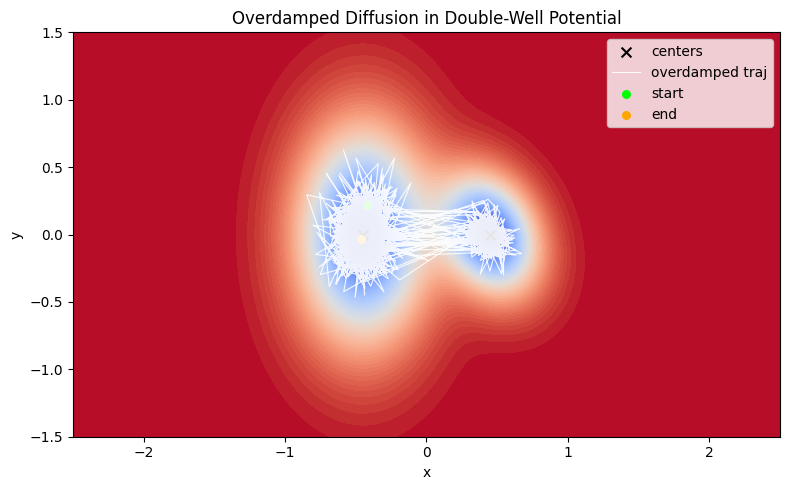

In [ ]:
# new double-well potential (different wells) + overdamped Langevin (Smoluchowski) SDE simulation

# Parameters for new double well (different centers, depths, spreads, rotation)
mu1_b = np.array([-0.45,  0])
mu2_b = np.array([ 0.45, -0])
A1_b = 4.5   # depth well 1
A2_b = 4.5   # depth well 2
kT = 0.4

# Plot potential contours and trajectory
# grid for contour
xs = np.linspace(-2.5, 2.5, 300)
ys = np.linspace(-1.5, 1.5, 240)
X, Y = np.meshgrid(xs, ys)
XY = np.stack([X.ravel(), Y.ravel()], axis=1)


Sigma1_b = np.array([[0.1, 0.0],
                      [0.0,  0.3]])
# rotated anisotropic covariance for well 2
theta = 0.35  # rotation angle
R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
Sdiag = np.diag([0.05, 0.1])
Sigma2_b = R @ Sdiag @ R.T

Sigma1_b_inv = np.linalg.inv(Sigma1_b)
Sigma2_b_inv = np.linalg.inv(Sigma2_b)

def potential_b(x):
    """Scalar potential V_b(x). x can be shape (2,) or (...,2)."""
    dx1 = x - mu1_b
    dx2 = x - mu2_b
    # handle both (2,) and (...,2)
    if dx1.ndim == 1:
        d1 = dx1 @ Sigma1_b_inv @ dx1
        d2 = dx2 @ Sigma2_b_inv @ dx2
    else:
        d1 = np.einsum('...i,ij,...j->...', dx1, Sigma1_b_inv, dx1)
        d2 = np.einsum('...i,ij,...j->...', dx2, Sigma2_b_inv, dx2)
    return -A1_b * np.exp(-0.5 * d1) - A2_b * np.exp(-0.5 * d2)

def grad_potential_b(x):
    """Gradient of V_b at a single 2-vector x."""
    dx1 = x - mu1_b
    dx2 = x - mu2_b
    d1 = dx1 @ Sigma1_b_inv @ dx1
    d2 = dx2 @ Sigma2_b_inv @ dx2
    g1 = A1_b * np.exp(-0.5 * d1) * (Sigma1_b_inv @ dx1)
    g2 = A2_b * np.exp(-0.5 * d2) * (Sigma2_b_inv @ dx2)
    return g1 + g2

# SDE (overdamped Langevin): dx = -grad V * dt + sqrt(2*kT*dt) * N(0,1)
dt_b = 2e-3
n_steps_b = int(1e6)   # total steps
save_every_b = 15      # store every N steps
np.random.seed(123)

x0 = np.array([0.3, 0.6])
x_b = x0.copy()

traj_b = []
sqrt_term = np.sqrt(2.0 * kT * dt_b)
for t in range(n_steps_b):
    g = grad_potential_b(x_b)
    x_b = x_b - g * dt_b + sqrt_term * np.random.randn(2)
    if t % save_every_b == 0:
        traj_b.append(x_b.copy())
traj_b = np.array(traj_b)

# compute potential grid for plotting (reuse X,Y,XY from previous cell)
Z_b = potential_b(XY).reshape(X.shape)

# plotting: potential contours, trajectory, centers, and empirical density
plt.figure(figsize=(8,5))
levels_b = np.linspace(Z_b.min(), Z_b.max(), 60)
plt.contourf(X, Y, Z_b, levels=levels_b, cmap='coolwarm')
plt.scatter([mu1_b[0], mu2_b[0]], [mu1_b[1], mu2_b[1]], c='k', s=50, marker='x', label='centers')
pts_b = traj_b[25000::max(1, traj_b.shape[0] // 1500)]
plt.plot(pts_b[:,0], pts_b[:,1], color='white', lw=0.8, alpha=0.9, label='overdamped traj')
plt.scatter(pts_b[0,0], pts_b[0,1], c='lime', s=30, label='start')
plt.scatter(pts_b[-1,0], pts_b[-1,1], c='orange', s=30, label='end')
plt.xlabel('x'); plt.ylabel('y')
plt.title('Overdamped Diffusion in Double-Well Potential')
plt.legend()
plt.tight_layout()
plt.show()
np.save('./data/traj_b.npy', traj_b[25000:])  # save trajectory for later use

In [ ]:
traj_b=np.load('./data/traj_b.npy')
L=200
slid_mean, slid_cov = sliding_windows(traj_b[:,1], window_size=L) 

# The EM algorithm
In this part we show how in R^d it is possible to cluster our datapoints using a simple version of EM.

Iteration 1: mus=[ 1 -1], sigmas=[1. 1.], pis=[0.5 0.5]


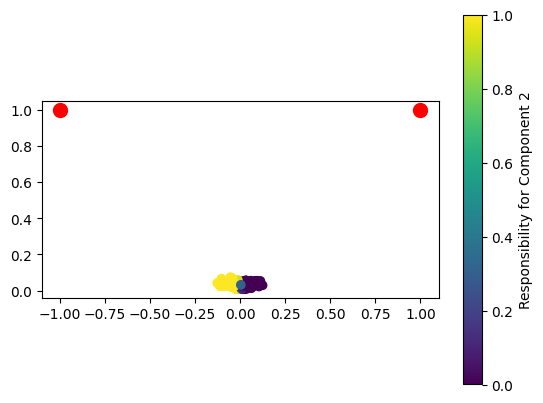

Iteration 6: mus=[ 0.0231852  -0.03575668], sigmas=[0.1702329  0.19220417], pis=[0.66485662 0.33514338]


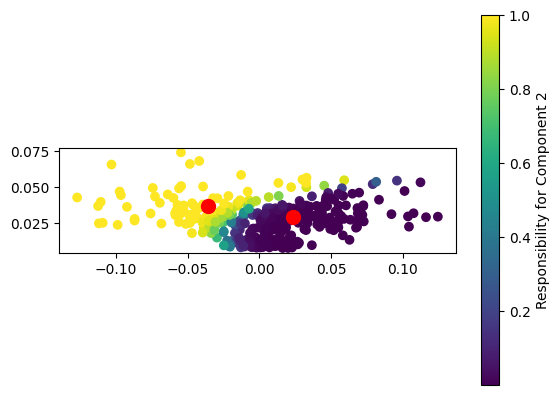

Iteration 11: mus=[ 0.01350002 -0.01518749], sigmas=[0.15492758 0.20521347], pis=[0.64901784 0.35098216]


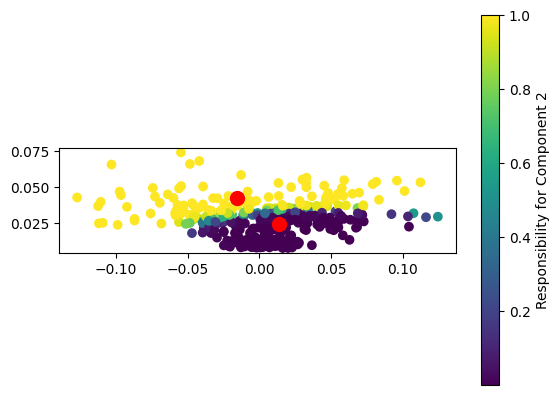

Iteration 16: mus=[0.0066525  0.00082473], sigmas=[0.13499229 0.19745635], pis=[0.44725253 0.55274747]


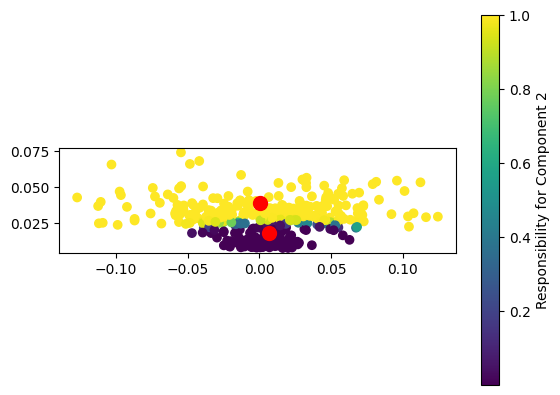

Iteration 21: mus=[0.00392017 0.00324983], sigmas=[0.10633231 0.19040131], pis=[0.27058552 0.72941448]


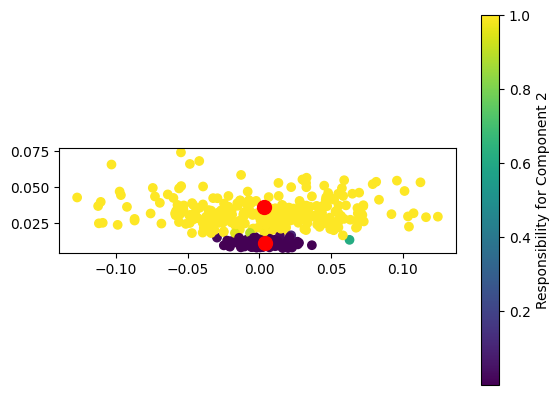

Iteration 26: mus=[0.00383801 0.00328278], sigmas=[0.10580938 0.19028432], pis=[0.26734269 0.73265731]


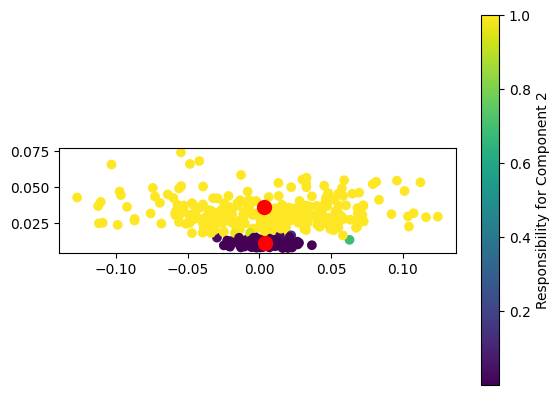

In [5]:
mus = np.array([1, -1])
sigmas = np.array([1, 1])**0.5
pis = np.array([0.5, 0.5])

obs = np.vstack([slid_mean[::100], slid_cov[::100]]).T

for i in range(26):
    responsibilities = E_step(obs, mus, sigmas, pis, L=L)
    if i%5==0:
        print(f"Iteration {i+1}: mus={mus}, sigmas={sigmas}, pis={pis}")
        plt.scatter(slid_mean[::100], slid_cov[::100], c=responsibilities[:,1])
        plt.plot(mus, sigmas**2, 'ro', markersize=10)
        plt.colorbar(label='Responsibility for Component 2')
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()
    mus, sigmas, pis = M_step(obs, responsibilities, L=L)



Text(0.5, 1.0, 'X')

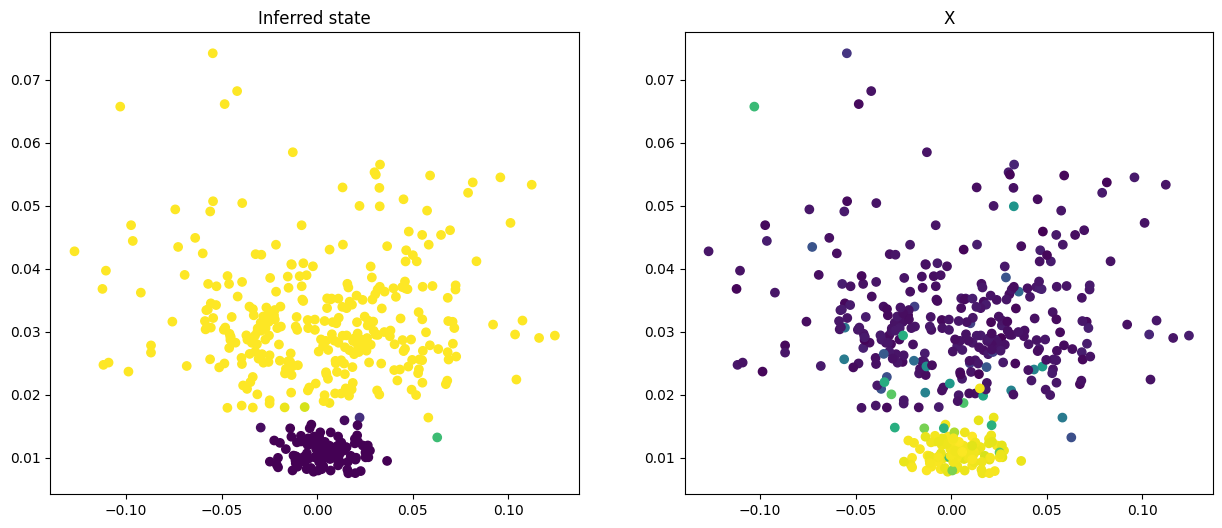

In [ ]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121)
ax.scatter(slid_mean[::100], slid_cov[::100], c=responsibilities[:,1])
ax.set_title('Inferred state')

ax1 = fig.add_subplot(122)
slid_x, _ = sliding_windows(traj_b[25000:,0], window_size=L)
ax1.scatter(slid_mean[::100], slid_cov[::100], c=slid_x[::100])
ax1.set_title('X') #here we color the points by the value of the mean of X in the sliding window, which should differentiate the states

# Model selection
In the next part we show how to select the number of clusters.

In [4]:
from sklearn.metrics import adjusted_mutual_info_score, normalized_mutual_info_score
import numpy as np

import matplotlib.pyplot as plt

from network_reconstruction.utils import E_step, M_step, sliding_windows

traj_b=np.load('./data/traj_b.npy')
L=200
slid_mean, slid_cov = sliding_windows(traj_b[:,1], window_size=L) 

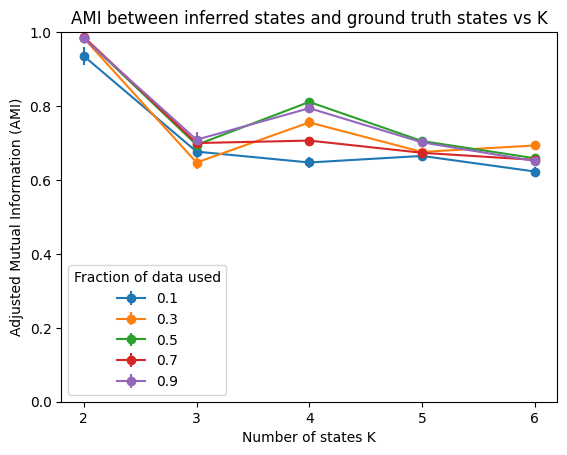

In [9]:
obs_tot = np.vstack([slid_mean, slid_cov]).T


total=1000
repetitions=50

np.random.seed(30)

for frac in [0.1, 0.3, 0.5, 0.7, 0.9]:
    subsample = int(total*frac)
    ami_mean_k=[]
    ami_std_k=[]

    for k in [2,3,4,5,6]:
        obs=obs_tot[np.random.choice(obs_tot.shape[0], size=total, replace=False)]
        mus_star = np.random.uniform(-3, 3, size=k)
        sigmas_star = np.random.uniform(1, 5, size=k)
        pis_star = np.ones(k) / 3

        for i in range(100):
            responsibilities = E_step(obs, mus_star, sigmas_star, pis_star, L=L)
            mus_star, sigmas_star, pis_star = M_step(obs, responsibilities, L=L)

        ami_scores = []

        for _ in range(repetitions):
            obs=obs_tot[np.random.choice(obs_tot.shape[0], size=subsample, replace=False)]

            mus = np.random.uniform(-0.1, 0.1, size=k)
            sigmas = np.random.uniform(0.2, 1, size=k)
            pis = np.ones(k) / 3

            for i in range(100):
                responsibilities = E_step(obs, mus, sigmas, pis, L=L)
                mus, sigmas, pis = M_step(obs, responsibilities, L=L)
            
            label_sub = np.argmax(E_step(obs, mus, sigmas, pis, L=L), axis=1)
            label_total = np.argmax(E_step(obs, mus_star, sigmas_star, pis_star, L=L), axis=1)
            #
            #plt.scatter(obs[:,0], obs[:,1], c=label_sub)
            #plt.plot(mus, np.array(sigmas)**2, 'ro')
            #plt.show()
            #plt.scatter(obs[:,0], obs[:,1], c=label_total, marker='x')
            #plt.plot(mus_star, np.array(sigmas_star)**2, 'go')
            #plt.show()
            ami_scores.append(adjusted_mutual_info_score(label_total, label_sub))
        
        ami_mean_k.append(np.mean(ami_scores))
        ami_std_k.append(np.std(ami_scores)/np.sqrt(len(ami_scores)))
    plt.errorbar([2,3,4,5,6], ami_mean_k, yerr=ami_std_k, fmt='o-', label=f'{frac}')

plt.xlabel('Number of states K')
plt.ylabel('Adjusted Mutual Information (AMI)')
plt.title('AMI between inferred states and ground truth states vs K')
plt.xticks([2,3,4,5,6])
plt.ylim(0,1)
plt.legend(title='Fraction of data used')
plt.show()

# Transition trajectories

In this part of the notebook, we show how to see and recognise the trajectories connecting the metastable states.

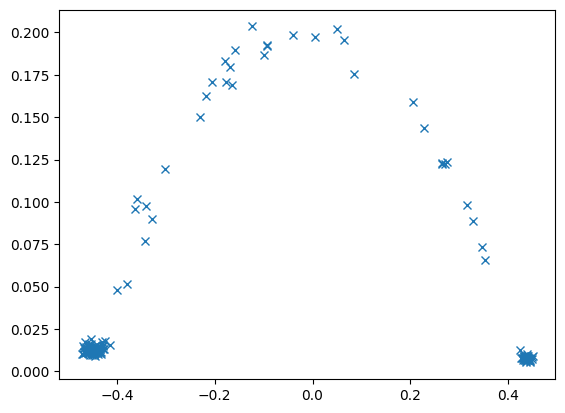

In [ ]:
slid_x, var_x = sliding_windows(traj_b[25000:,0], window_size=L)
plt.plot(slid_x[::100], var_x[::100], 'x') #You get a parabolic transition trajectory